In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from sklearn.model_selection import train_test_split
import kagglehub as kh
from sklearn.metrics import confusion_matrix

NORMALIZE_COUNTS = True

In [42]:
path = kh.dataset_download("uciml/msd-audio-features")
print("Path to dataset files:", path)
data_by_decade = pd.read_csv(path + "/year_prediction.csv")
# data_by_ear doesn't have the year labels squashed into decades
data_by_year = pd.read_csv(path + "/year_prediction.csv")

# check for NA
data_dropped = data_by_decade.dropna()
if len(data_dropped) == len(data_by_decade):
    print("No NA")

def convert_year(year):
    year_str = str(int(year["label"]))
    year_str = year_str[:-1] + '0'
    year_str += 's'
    return year_str

data_by_decade["label"] = data_by_decade.apply(convert_year, axis=1)

labels_trim = data_by_decade["label"]
labels_trim = labels_trim.replace({"2010s": "2000s"})
labels_trim = labels_trim.replace({"2000s": "2000s"})
labels_trim = labels_trim.replace({"1990s": "1990s"})
labels_trim = labels_trim.replace({"1980s": "1980s"})
labels_trim = labels_trim.replace({"1970s": "1970s"})
labels_trim = labels_trim.replace({"1960s": "<=1960s"})
labels_trim = labels_trim.replace({"1950s":  "<=1960s"})
labels_trim = labels_trim.replace({"1940s": "<=1960s"})
labels_trim = labels_trim.replace({"1930s":  "<=1960s"})
labels_trim = labels_trim.replace({"1920s":  "<=1960s"})
data_by_decade["label"] = labels_trim

data_by_decade, test_big = train_test_split(data_by_decade, train_size=0.7, random_state=42, stratify=data_by_decade["label"])

if NORMALIZE_COUNTS:
    min_count = data_by_decade['label'].value_counts().min()
    data_by_decade = data_by_decade.groupby('label').apply(lambda x: x.sample(min_count, replace=True)).reset_index(drop=True)

X = data_by_decade.drop(columns=[ "label"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
data_by_decade = pd.concat([pd.DataFrame(data_by_decade["label"]), pd.DataFrame(X_scaled, columns=X.columns)], axis=1)

data_by_decade["label"].value_counts()

Path to dataset files: /home/zato-1/.cache/kagglehub/datasets/uciml/msd-audio-features/versions/1
No NA


/tmp/ipykernel_8473/1641541845.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_by_decade = data_by_decade.groupby('label').apply(lambda x: x.sample(min_count, replace=True)).reset_index(drop=True)


label
1970s      10971
1980s      10971
1990s      10971
2000s      10971
<=1960s    10971
Name: count, dtype: int64

In [43]:
from sklearn.metrics import r2_score

def adjr2(pred, test, p):
    r2 = r2_score(test, pred)
    n = len(test)
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

In [44]:
avg_cols = [f'TimbreAvg{i}' for i in range(1, 13)]
cov_cols = [f'TimbreCovariance{i}' for i in range(1, 79)]
feature_cols = avg_cols + cov_cols

data_by_decade["label"] = data_by_decade["label"].astype("category")
label_lookup = dict(enumerate(data_by_decade['label'].cat.categories))
train, test = train_test_split(data_by_decade, train_size=0.7, random_state=42, stratify=data_by_decade["label"])
test_lookup = dict(enumerate(test['label'].cat.categories))
train_lookup = dict(enumerate(train['label'].cat.categories))
train["label"] = train["label"].cat.codes
test["label"] = test["label"].cat.codes
assert test_lookup == train_lookup
assert test_lookup == label_lookup

test_label = test["label"].astype("category").cat.codes
train_label = train["label"].astype("category").cat.codes
test.drop("label", axis=1, inplace=True)
train.drop("label", axis=1, inplace=True)

og_cat_test = test.copy()
og_cat_test_label = test_label.copy()

### CatBoost Training (full)

Learning rate set to 0.13661
0:	learn: 1.5765404	total: 6.18ms	remaining: 6.18s
1:	learn: 1.5510704	total: 12.8ms	remaining: 6.37s
2:	learn: 1.5290633	total: 18.3ms	remaining: 6.07s
3:	learn: 1.5100688	total: 23.8ms	remaining: 5.92s
4:	learn: 1.4931490	total: 30.6ms	remaining: 6.1s
5:	learn: 1.4794211	total: 36ms	remaining: 5.96s
6:	learn: 1.4659903	total: 42.2ms	remaining: 5.99s
7:	learn: 1.4548808	total: 48.5ms	remaining: 6.01s
8:	learn: 1.4437348	total: 54ms	remaining: 5.95s
9:	learn: 1.4344108	total: 60.5ms	remaining: 5.99s
10:	learn: 1.4254459	total: 66.5ms	remaining: 5.98s
11:	learn: 1.4177283	total: 71.9ms	remaining: 5.92s
12:	learn: 1.4097715	total: 78.6ms	remaining: 5.96s
13:	learn: 1.4019077	total: 84.3ms	remaining: 5.93s
14:	learn: 1.3952828	total: 89.7ms	remaining: 5.89s
15:	learn: 1.3879840	total: 96.8ms	remaining: 5.95s
16:	learn: 1.3810969	total: 102ms	remaining: 5.92s
17:	learn: 1.3752916	total: 109ms	remaining: 5.92s
18:	learn: 1.3685990	total: 115ms	remaining: 5.92s
1

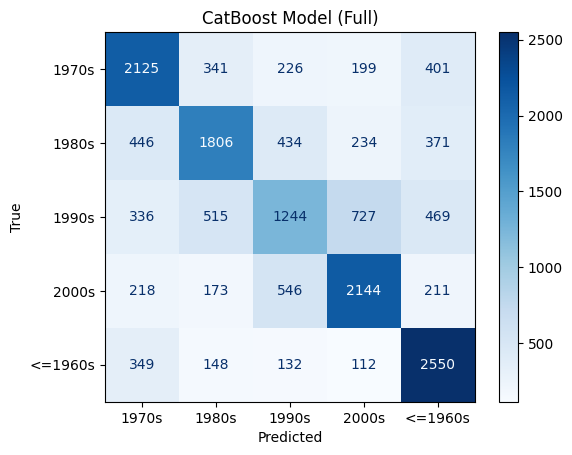

In [45]:
from catboost import CatBoostClassifier
cat_model = CatBoostClassifier(task_type="GPU", iterations=1000, devices='0')
cat_res = cat_model.fit(train, train_label)

# CATBOOST ACCURACY
pred = cat_model.predict(test)
test_label_list = test_label.tolist()
num_right = 0

for i in range(len(pred)):
    if test_label_list[i] == pred[i]:
        num_right += 1

percent_right = num_right / len(pred)
print(percent_right)
print(adjr2(test_label, pred, len(train.columns) - 1))

# confusion matrix
matrix = confusion_matrix(test_label, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap=plt.cm.Blues)

labels = list(label_lookup.values())
tick_marks = np.arange(len(labels))

plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("CatBoost Model (Full)")

plt.savefig('figs/catboost-full.png')
plt.show()

### Multinom Training (full)

/home/zato-1/.venv/music/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


0.48617609527860484
0.1650327132915923


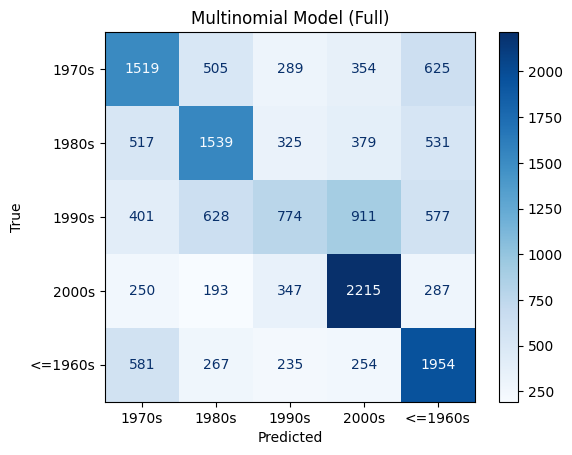

In [46]:
multinomial_model = LogisticRegression(multi_class='multinomial')
multi_res = multinomial_model.fit(train, train_label)

# MULTINOMIAL ACCURACY
multi_preds = multi_res.predict(test)

correct = 0
for i, label in enumerate(test_label):
    if label == multi_preds[i]:
        correct += 1

acc = correct / len(test_label)
print(acc)
print(adjr2(test_label, pred, len(train.columns) - 1))
# confusion matrix
matrix = confusion_matrix(test_label, multi_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap=plt.cm.Blues)

labels = list(label_lookup.values())
tick_marks = np.arange(len(labels))

plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Multinomial Model (Full)")

plt.savefig('figs/multinom-full.png')
plt.show()

### Multinom Reduced

In [47]:
# sample down
df_sample = data_by_decade
if len (data_by_decade) > 100000:
    df_sample =  train_test_split(data_by_decade, train_size=(100000 / len(data_by_decade)), random_state=42, stratify=data_by_decade["label"])
else:
    df_sample =  train_test_split(data_by_decade, train_size=(10000 / len(data_by_decade)), random_state=42, stratify=data_by_decade["label"])
df_sample = pd.DataFrame(df_sample[0], columns=data_by_decade.columns)

sample_train, sample_test = train_test_split(df_sample, train_size=0.7, random_state=42, stratify=df_sample["label"])

sample_test_label = sample_test["label"].astype("category").cat.codes
sample_train_label = sample_train["label"].astype("category").cat.codes
sample_test.drop("label", axis=1, inplace=True)
sample_train.drop("label", axis=1, inplace=True)


In [48]:
# ___________Find Best Alpha___________
param_grid = {'alpha': np.linspace(0.01, 1, 25)} 
grid_search = GridSearchCV(Lasso(), param_grid, cv=5)
grid_search.fit(sample_train, sample_train_label)

# Get the best parameters and best score
best_alpha = grid_search.best_params_['alpha']
best_score = grid_search.best_score_

# Fit the model with the best alpha
lasso_best = Lasso(alpha=best_alpha)
lasso_best.fit(sample_train, sample_train_label)

# Evaluate the performance on the test set
test_score = lasso_best.score(sample_test, sample_test_label)

print(f"Best alpha from GridSearchCV: {best_alpha}")
print(f"Best cross-validation score: {best_score}")
print(f"Test R^2 score: {test_score}")


# ___________Apply Best Alpha___________

lasso = Lasso(alpha=best_alpha, random_state=1)
lasso.fit(sample_train, sample_train_label)

coef = pd.Series(lasso.coef_, index=feature_cols)
selected_features = coef[coef != 0]

# Sort by the absolute value but retain the original sign
sorted_by_abs_value = selected_features.reindex(selected_features.abs().sort_values(ascending=False).index)

num_features = len(sorted_by_abs_value)
print(f"\n{num_features} Selected Features by LASSO (sorted by absolute value):")
print(sorted_by_abs_value)


Best alpha from GridSearchCV: 0.01
Best cross-validation score: 0.10636337985693531
Test R^2 score: 0.10319502844412232

66 Selected Features by LASSO (sorted by absolute value):
TimbreAvg1            0.320372
TimbreAvg2           -0.253917
TimbreAvg11          -0.185672
TimbreAvg7           -0.132152
TimbreCovariance2     0.098432
                        ...   
TimbreCovariance75    0.003547
TimbreCovariance23    0.002746
TimbreCovariance29   -0.002629
TimbreCovariance14   -0.000649
TimbreCovariance38   -0.000259
Length: 66, dtype: float64


In [49]:
reduced_features = sorted_by_abs_value.index.to_list()
data_by_decade_reduced = data_by_decade.drop(columns=reduced_features)


train_reduced, test_reduced = train_test_split(data_by_decade_reduced, train_size=0.7, random_state=42, stratify=data_by_decade_reduced["label"])

test_reduced_label = test_reduced["label"].astype("category").cat.codes
train_reduced_label = train_reduced["label"].astype("category").cat.codes
test_reduced.drop("label", axis=1, inplace=True)
train_reduced.drop("label", axis=1, inplace=True)

/home/zato-1/.venv/music/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


0.1650327132915923


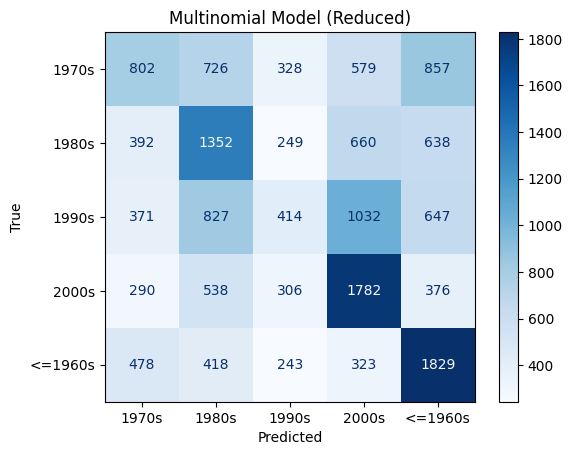

In [50]:
multinomial_model = LogisticRegression(multi_class='multinomial')
multi_res = multinomial_model.fit(train_reduced, train_reduced_label)

# MULTINOMIAL ACCURACY
multi_preds = multi_res.predict(test_reduced)

correct = 0
for i, label in enumerate(test_reduced_label):
    if label == multi_preds[i]:
        correct += 1

correct / len(test_label)
print(adjr2(test_label, pred, len(train.columns) - 1))

# confusion matrix
matrix = confusion_matrix(test_reduced_label, multi_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap=plt.cm.Blues)

labels = list(label_lookup.values())
tick_marks = np.arange(len(labels))

plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title('Multinomial Model (Reduced)')

plt.savefig('figs/multinom-reduced.png')
plt.show()

### CatBoost Reduced

In [51]:
from catboost import CatBoostClassifier
cat_model = CatBoostClassifier(task_type="GPU", iterations=1000, devices='0')
cat_res = cat_model.fit(train, train_label)

Learning rate set to 0.13661
0:	learn: 1.5765401	total: 6.59ms	remaining: 6.58s
1:	learn: 1.5510704	total: 12.1ms	remaining: 6.01s
2:	learn: 1.5290635	total: 19ms	remaining: 6.32s
3:	learn: 1.5100685	total: 24.6ms	remaining: 6.12s
4:	learn: 1.4931489	total: 31.5ms	remaining: 6.27s
5:	learn: 1.4794209	total: 37.3ms	remaining: 6.17s
6:	learn: 1.4659903	total: 43.4ms	remaining: 6.16s
7:	learn: 1.4548812	total: 50.2ms	remaining: 6.22s
8:	learn: 1.4437348	total: 55.8ms	remaining: 6.14s
9:	learn: 1.4344108	total: 61.3ms	remaining: 6.06s
10:	learn: 1.4254459	total: 68.2ms	remaining: 6.13s
11:	learn: 1.4177281	total: 73.7ms	remaining: 6.07s
12:	learn: 1.4097717	total: 80.9ms	remaining: 6.14s
13:	learn: 1.4019077	total: 86.9ms	remaining: 6.12s
14:	learn: 1.3952827	total: 92.4ms	remaining: 6.07s
15:	learn: 1.3879838	total: 99.1ms	remaining: 6.09s
16:	learn: 1.3810971	total: 105ms	remaining: 6.05s
17:	learn: 1.3752918	total: 110ms	remaining: 6s
18:	learn: 1.3685989	total: 117ms	remaining: 6.03s
1

In [52]:
cat_res.feature_names_
cat_res.feature_importances_
sorted_importances = sorted(zip(cat_res.feature_names_, cat_res.feature_importances_), key=lambda x: x[1], reverse=True)
sorted_importances

top = sorted_importances[:70]
top_names = [x[0] for x in top]

top_names
remaining_names = [x for x in cat_res.feature_names_ if x not in top_names]
remaining_names

['TimbreCovariance6',
 'TimbreCovariance9',
 'TimbreCovariance18',
 'TimbreCovariance19',
 'TimbreCovariance20',
 'TimbreCovariance23',
 'TimbreCovariance30',
 'TimbreCovariance32',
 'TimbreCovariance39',
 'TimbreCovariance50',
 'TimbreCovariance52',
 'TimbreCovariance54',
 'TimbreCovariance60',
 'TimbreCovariance63',
 'TimbreCovariance69',
 'TimbreCovariance72',
 'TimbreCovariance74',
 'TimbreCovariance75',
 'TimbreCovariance76',
 'TimbreCovariance77']

In [53]:
data_by_decade_reduced_by_importance = data_by_decade.drop(columns=remaining_names)


train_reduced_by_importance, test_reduced_by_importance = train_test_split(data_by_decade_reduced_by_importance, train_size=0.7, random_state=42, stratify=data_by_decade_reduced_by_importance["label"])

test_reduced_by_importance_label = test_reduced_by_importance["label"].astype("category").cat.codes
train_reduced_by_importance_label = train_reduced_by_importance["label"].astype("category").cat.codes
test_reduced_by_importance.drop("label", axis=1, inplace=True)
train_reduced_by_importance.drop("label", axis=1, inplace=True)

Learning rate set to 0.13661
0:	learn: 1.5765402	total: 4.97ms	remaining: 4.97s
1:	learn: 1.5510706	total: 9.33ms	remaining: 4.66s
2:	learn: 1.5290633	total: 14.4ms	remaining: 4.77s
3:	learn: 1.5100688	total: 19ms	remaining: 4.73s
4:	learn: 1.4931490	total: 23.2ms	remaining: 4.63s
5:	learn: 1.4794208	total: 27.5ms	remaining: 4.55s
6:	learn: 1.4659898	total: 33ms	remaining: 4.68s
7:	learn: 1.4548809	total: 37.4ms	remaining: 4.64s
8:	learn: 1.4437347	total: 41.7ms	remaining: 4.59s
9:	learn: 1.4344108	total: 46ms	remaining: 4.55s
10:	learn: 1.4254459	total: 51.2ms	remaining: 4.6s
11:	learn: 1.4177282	total: 55.4ms	remaining: 4.56s
12:	learn: 1.4097716	total: 59.4ms	remaining: 4.51s
13:	learn: 1.4019078	total: 64.4ms	remaining: 4.53s
14:	learn: 1.3952825	total: 68.6ms	remaining: 4.51s
15:	learn: 1.3879840	total: 72.9ms	remaining: 4.48s
16:	learn: 1.3810972	total: 77.5ms	remaining: 4.48s
17:	learn: 1.3752920	total: 82.8ms	remaining: 4.52s
18:	learn: 1.3685990	total: 87.2ms	remaining: 4.5s
1

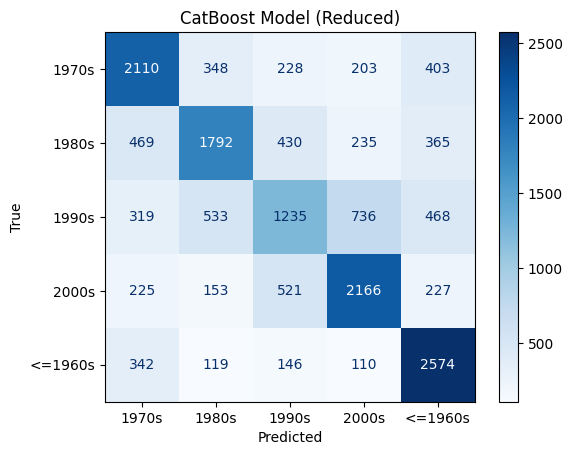

In [54]:
from catboost import CatBoostClassifier
cat_model = CatBoostClassifier(task_type="GPU", iterations=1000, devices='0')
cat_res = cat_model.fit(train_reduced_by_importance, train_reduced_by_importance_label) 

pred = cat_model.predict(test_reduced_by_importance)
test_label_list = test_reduced_by_importance_label.tolist()
num_right = 0

for i in range(len(pred)):
    if test_label_list[i] == pred[i]:
        num_right += 1

percent_right = num_right / len(pred)
print(percent_right)
#print(adjr2(train_reduced_by_importance, pred, len(train_reduced_by_importance.columns) - 1))

# confusion matrix
matrix = confusion_matrix(test_reduced_by_importance_label, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap=plt.cm.Blues)

labels = list(label_lookup.values())
tick_marks = np.arange(len(labels))

plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title('CatBoost Model (Reduced)')

plt.savefig('figs/catboost-reduced.png')

plt.show()

0.5949328607280536


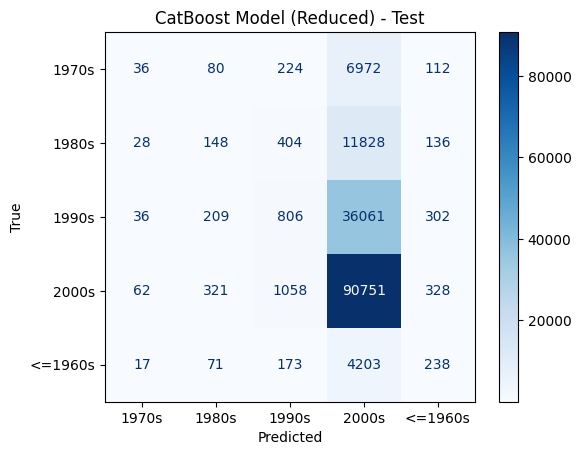

In [55]:
test_big_label = test_big["label"].astype("category").cat.codes
test_big.drop("label", axis=1, inplace=True)

pred = cat_model.predict(test_big)
test_label_list = test_big_label.tolist()
num_right = 0
#
for i in range(len(pred)):
    if test_label_list[i] == pred[i]:
        num_right += 1

percent_right = num_right / len(pred)
print(percent_right)
#print(adjr2(test_big_label, pred, len(train.columns) - 1))

# confusion matrix
matrix = confusion_matrix(test_big_label, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap=plt.cm.Blues)

labels = list(label_lookup.values())
tick_marks = np.arange(len(labels))

plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("CatBoost Model (Reduced) - Test")

plt.savefig("figs/catboost-reduced-test.png")
plt.show()